# ABJAstroalign Source Code

In [ ]:

__version__ = "2.5.1"

__all__ = [
    "MIN_MATCHES_FRACTION",
    "MaxIterError",
    "NUM_NEAREST_NEIGHBORS",
    "PIXEL_TOL",
    "apply_transform",
    "estimate_transform",
    "find_transform",
    "matrix_transform",
    "register",
]

#try:
#    import bottleneck as bn
#except ImportError:
HAS_BOTTLENECK = False
#else:
#    HAS_BOTTLENECK = True

import numpy as _np

def testing_testing():
    return(True)


def estimate_transform(*args, **kwargs):
    """Lazy-loader function for skimage.transform.estimate_transform.

    Full documentation:
    https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.estimate_transform
    """
    from skimage.transform import estimate_transform

    return estimate_transform(*args, **kwargs)


def matrix_transform(*args, **kwargs):
    """Lazy-loader function for skimage.transform.matrix_transform.

    Full documentation:
    https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.matrix_transform
    """
    from skimage.transform import matrix_transform

    return matrix_transform(*args, **kwargs)


PIXEL_TOL = 2
"""The pixel distance tolerance to assume two invariant points are the same.

Default: 2"""

MIN_MATCHES_FRACTION = 0.8
"""The minimum fraction of triangle matches to accept a transformation.

If the minimum fraction yields more than 10 triangles, 10 is used instead.

Default: 0.8
"""

NUM_NEAREST_NEIGHBORS = 5
"""
The number of nearest neighbors of a given star (including itself) to construct
the triangle invariants.

Default: 5
"""

_default_median = _np.nanmedian  # pragma: no cover
"""
Default median function when/if optional bottleneck is available
"""

_default_average = _np.nanmean  # pragma: no cover
"""
Default mean function when/if optional bottleneck is available
"""

_default_sum = _np.nansum  # pragma: no cover
"""
Default sum function when/if optional bottleneck is available
"""

_default_std = _np.nanstd  # pragma: no cover
"""
Default std deviation function when/if optional bottleneck is available
"""


def _invariantfeatures(x1, x2, x3):
    """Given 3 points x1, x2, x3, return the invariant features for the set."""
    sides = _np.sort(
        [
            _np.linalg.norm(x1 - x2),
            _np.linalg.norm(x2 - x3),
            _np.linalg.norm(x1 - x3),
        ]
    )
    return [sides[2] / sides[1], sides[1] / sides[0]]


def _arrangetriplet(sources, vertex_indices):
    """Order vertex_indices according to length side.

    Order in (a, b, c) form Where:
      a is the vertex defined by L1 & L2
      b is the vertex defined by L2 & L3
      c is the vertex defined by L3 & L1
    and L1 < L2 < L3 are the sides of the triangle
    defined by vertex_indices.
    """
    ind1, ind2, ind3 = vertex_indices
    x1, x2, x3 = sources[vertex_indices]

    side_ind = _np.array([(ind1, ind2), (ind2, ind3), (ind3, ind1)])
    side_lengths = list(map(_np.linalg.norm, (x1 - x2, x2 - x3, x3 - x1)))
    l1_ind, l2_ind, l3_ind = _np.argsort(side_lengths)

    # the most common vertex in the list of vertices for two sides is the
    # point at which they meet.
    from collections import Counter

    count = Counter(side_ind[[l1_ind, l2_ind]].flatten())
    a = count.most_common(1)[0][0]
    count = Counter(side_ind[[l2_ind, l3_ind]].flatten())
    b = count.most_common(1)[0][0]
    count = Counter(side_ind[[l3_ind, l1_ind]].flatten())
    c = count.most_common(1)[0][0]

    return _np.array([a, b, c])


def _generate_invariants(sources):
    """Return an array of (unique) invariants derived from the array `sources`.

    Return an array of the indices of `sources` that correspond to each
    invariant, arranged as described in _arrangetriplet.
    """
    from scipy.spatial import KDTree
    from itertools import combinations
    from functools import partial

   # sources = _np.asarray([[p.pt[0], p.pt[1]] for p in kp])

    arrange = partial(_arrangetriplet, sources=sources)

    inv = []
    triang_vrtx = []
    coordtree = KDTree(sources)
    # The number of nearest neighbors to request (to work with few sources)
    knn = min(len(sources), NUM_NEAREST_NEIGHBORS)
    for asrc in sources:
        __, indx = coordtree.query(asrc, knn)

        # Generate all possible triangles with the 5 indx provided, and store
        # them with the order (a, b, c) defined in _arrangetriplet
        all_asterism_triang = [
            arrange(vertex_indices=list(cmb)) for cmb in combinations(indx, 3)
        ]
        triang_vrtx.extend(all_asterism_triang)

        inv.extend(
            [
                _invariantfeatures(*sources[triplet])
                for triplet in all_asterism_triang
            ]
        )

    # Remove here all possible duplicate triangles
    uniq_ind = [
        pos for (pos, elem) in enumerate(inv) if elem not in inv[pos + 1 :]
    ]
    inv_uniq = _np.array(inv)[uniq_ind]
    triang_vrtx_uniq = _np.array(triang_vrtx)[uniq_ind]

    return inv_uniq, triang_vrtx_uniq


class _MatchTransform:
    def __init__(self, source, target):
        self.source = source
        self.target = target

    def fit(self, data):
        """
        Return the best 2D similarity transform from the points given in data.

        data: N sets of similar corresponding triangles.
            3 indices for a triangle in ref
            and the 3 indices for the corresponding triangle in target;
            arranged in a (N, 3, 2) array.
        """
        d1, d2, d3 = data.shape
        s, d = data.reshape(d1 * d2, d3).T
        # approx_t = estimate_transform(
        #     "similarity", self.source[s], self.target[d]
        # )
        approx_t = estimate_transform(
            "projective", self.source[s], self.target[d]
        )
        return approx_t

    def get_error(self, data, approx_t):
        d1, d2, d3 = data.shape
        s, d = data.reshape(d1 * d2, d3).T
        resid = approx_t.residuals(self.source[s], self.target[d]).reshape(
            d1, d2
        )
        error = resid.max(axis=1)
        return error


def _data(image):
    """Return the bare 2D numpy array with pixel information."""
    if hasattr(image, "data") and isinstance(image.data, _np.ndarray):
        return image.data
    return _np.asarray(image)


def _mask(image):
    """Return a 2D numpy mask array if any, or None if there is no mask."""
    if hasattr(image, "mask"):
        the_np_mask = _np.asarray(image.mask)
        if the_np_mask.ndim == 2:
            return the_np_mask
        else:
            return _np.logical_or.reduce(the_np_mask, axis=-1)
    return None


def _bw(image):
    """Return a 2D numpy array for an array of arbitrary channels."""
    if image.ndim == 2:
        return image
    return _default_average(image, axis=-1)


def _shape(image):
    """Return a 2D shape for the image, ignoring channel info."""
    if image.ndim == 2:
        return image.shape
    h, w, ch = image.shape
    return h, w


def find_transform(
    source, target, max_control_points=50, detection_sigma=5, min_area=5
):
    """Estimate the transform between ``source`` and ``target``.

    Return a SimilarityTransform object ``T`` that maps pixel x, y indices from
    the source image s = (x, y) into the target (destination) image t = (x, y).
    T contains parameters of the tranformation: ``T.rotation``,
    ``T.translation``, ``T.scale``, ``T.params``.

    Parameters
    ----------
        source
            A 2D NumPy, CCData or NDData array of the source image to be transformed
            or an interable of (x, y) coordinates of the source control points.
        target
            A 2D NumPy, CCData or NDData array of the target (destination) image
            or an interable of (x, y) coordinates of the target control points.
        max_control_points
            The maximum number of control point-sources to find the transformation.
        detection_sigma : int
            Factor of background std-dev above which is considered a detection.
            This value is ignored if input are not images.
        min_area : int
            Minimum number of connected pixels to be considered a source.
            This value is ignored if input are not images.

    Returns
    -------
        T, (source_pos_array, target_pos_array)
            The transformation object and a tuple of corresponding star positions
            in source and target.

    Raises
    ------
        TypeError
            If input type of ``source`` or ``target`` is not supported.
        ValueError
            If it cannot find more than 3 stars on any input.
        MaxIterError
            If no transformation is found.
    """
    from scipy.spatial import KDTree

    try:
        if len(_data(source)[0]) == 2:
            # Assume it's a list of (x, y) pairs

            source_controlp = _np.array(source)[:max_control_points]
            print(source_controlp)

    except Exception:
        raise TypeError("Input type for source not supported.")

    try:
        if len(_data(target)[0]) == 2:
            # Assume it's a list of (x, y) pairs
            target_controlp = _np.array(target)[:max_control_points]

    except Exception:
        raise TypeError("Input type for target not supported.")

    # Check for low number of reference points
    if len(source_controlp) < 3:
        raise ValueError(
            "Reference stars in source image are less than the "
            "minimum value (3)."
        )
    if len(target_controlp) < 3:
        raise ValueError(
            "Reference stars in target image are less than the "
            "minimum value (3)."
        )

    source_invariants, source_asterisms = _generate_invariants(source_controlp)
    source_invariant_tree = KDTree(source_invariants)

    target_invariants, target_asterisms = _generate_invariants(target_controlp)
    target_invariant_tree = KDTree(target_invariants)

    # r = 0.1 is the maximum search distance, 0.1 is an empirical value that
    # returns about the same number of matches than inputs
    # matches_list is a list of lists such that for each element
    # source_invariant_tree.data[i], matches_list[i] is a list of the indices
    # of its neighbors in target_invariant_tree.data
    matches_list = source_invariant_tree.query_ball_tree(
        target_invariant_tree, r=0.1
    )



    # matches unravels the previous list of matches into pairs of source and
    # target control point matches.
    # matches is a (N, 3, 2) array. N sets of similar corresponding triangles.
    # 3 indices for a triangle in ref
    # and the 3 indices for the corresponding triangle in target;
    matches = []
    # t1 is an asterism in source, t2 in target
    for t1, t2_list in zip(source_asterisms, matches_list):
        for t2 in target_asterisms[t2_list]:
            matches.append(list(zip(t1, t2)))
    matches = _np.array(matches)

    inv_model = _MatchTransform(source_controlp, target_controlp)
    n_invariants = len(matches)
    # Set the minimum matches to be between 1 and 10 asterisms
    min_matches = max(1, min(10, int(n_invariants * MIN_MATCHES_FRACTION)))
    if (len(source_controlp) == 3 or len(target_controlp) == 3) and len(
        matches
    ) == 1:
        best_t = inv_model.fit(matches)
        inlier_ind = _np.arange(len(matches))  # All of the indices
    else:
        best_t, inlier_ind = _ransac(
            matches, inv_model, PIXEL_TOL, min_matches
        )
    triangle_inliers = matches[inlier_ind]
    d1, d2, d3 = triangle_inliers.shape
    inl_arr = triangle_inliers.reshape(d1 * d2, d3)
    inl_unique = set(tuple(pair) for pair in inl_arr)
    # In the next, multiple assignements to the same source point s are removed
    # We keep the pair (s, t) with the lowest reprojection error.
    inl_dict = {}
    for s_i, t_i in inl_unique:
        # calculate error
        s_vertex = source_controlp[s_i]
        t_vertex = target_controlp[t_i]
        t_vertex_pred = matrix_transform(s_vertex, best_t.params)
        error = _np.linalg.norm(t_vertex_pred - t_vertex)

        # if s_i not in dict, or if its error is smaller than previous error
        if s_i not in inl_dict or (error < inl_dict[s_i][1]):
            inl_dict[s_i] = (t_i, error)
    inl_arr_unique = _np.array(
        [[s_i, t_i] for s_i, (t_i, e) in inl_dict.items()]
    )
    s, d = inl_arr_unique.T

    return best_t, (source_controlp[s], target_controlp[d])






# Copyright (c) 2004-2007, Andrew D. Straw. All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are
# met:

#     * Redistributions of source code must retain the above copyright
#       notice, this list of conditions and the following disclaimer.

#     * Redistributions in binary form must reproduce the above
#       copyright notice, this list of conditions and the following
#       disclaimer in the documentation and/or other materials provided
#       with the distribution.

#     * Neither the name of the Andrew D. Straw nor the names of its
#       contributors may be used to endorse or promote products derived
#       from this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS
# "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT
# LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR
# a PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT
# OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL,
# SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT
# LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE,
# DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY
# THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
# (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
#
#
# Modified by Martin Beroiz


class MaxIterError(RuntimeError):
    """Raise if maximum iterations reached."""

    pass


def _ransac(data, model, thresh, min_matches):
    """Fit model parameters to data using the RANSAC algorithm.

    This implementation written from pseudocode found at
    http://en.wikipedia.org/w/index.php?title=RANSAC&oldid=116358182

    Parameters
    ----------
        data: a set of data points
        model: a model that can be fitted to data points
        thresh: a threshold value to determine when a data point fits a model
        min_matches: the min number of matches required to assert that a model
            fits well to data
    Returns
    -------
        bestfit: model parameters which best fit the data (or nil if no good
                  model is found)
    """
    good_fit = None
    n_data = data.shape[0]
    all_idxs = _np.arange(n_data)
    _np.random.default_rng().shuffle(all_idxs)

    for iter_i in range(n_data):
        # Partition indices into two random subsets
        maybe_idxs = all_idxs[iter_i : iter_i + 1]
        test_idxs = list(all_idxs[:iter_i])
        test_idxs.extend(list(all_idxs[iter_i + 1 :]))
        test_idxs = _np.array(test_idxs, dtype="i8")
        maybeinliers = data[maybe_idxs, :]
        test_points = data[test_idxs, :]
        maybemodel = model.fit(maybeinliers)
        test_err = model.get_error(test_points, maybemodel)
        # select indices of rows with accepted points
        also_idxs = test_idxs[test_err < thresh]
        alsoinliers = data[also_idxs, :]
        if len(alsoinliers) >= min_matches:
            good_data = _np.concatenate((maybeinliers, alsoinliers))
            good_fit = model.fit(good_data)
            break

    if good_fit is None:
        raise MaxIterError(
            "List of matching triangles exhausted before an acceptable "
            "transformation was found"
        )

    better_fit = good_fit
    for i in range(3):
        test_err = model.get_error(data, better_fit)
        better_inlier_idxs = _np.arange(n_data)[test_err < thresh]
        better_data = data[better_inlier_idxs]
        better_fit = model.fit(better_data)
    best_fit = better_fit
    best_inlier_idxs = better_inlier_idxs
    return best_fit, best_inlier_idxs


def find_homograpy_AJB(source_controlp, target_controlp,matches):


    inv_model = _MatchTransform(source_controlp, target_controlp)
    n_invariants = len(matches)
    # Set the minimum matches to be between 1 and 10 asterisms
    min_matches = max(1, min(10, int(n_invariants * MIN_MATCHES_FRACTION)))

    best_t, inlier_ind = _ransac(
            matches, inv_model, PIXEL_TOL, min_matches
        )

    triangle_inliers = matches[inlier_ind]
    d1, d2, d3 = triangle_inliers.shape
    inl_arr = triangle_inliers.reshape(d1 * d2, d3)
    inl_unique = set(tuple(pair) for pair in inl_arr)
    # In the next, multiple assignements to the same source point s are removed
    # We keep the pair (s, t) with the lowest reprojection error.
    inl_dict = {}
    for s_i, t_i in inl_unique:
        # calculate error
        s_vertex = source_controlp[s_i]
        t_vertex = target_controlp[t_i]
        t_vertex_pred = matrix_transform(s_vertex, best_t.params)
        error = _np.linalg.norm(t_vertex_pred - t_vertex)

        # if s_i not in dict, or if its error is smaller than previous error
        if s_i not in inl_dict or (error < inl_dict[s_i][1]):
            inl_dict[s_i] = (t_i, error)
    inl_arr_unique = _np.array(
        [[s_i, t_i] for s_i, (t_i, e) in inl_dict.items()]
    )
    s, d = inl_arr_unique.T

    return best_t, (source_controlp[s], target_controlp[d])
    #return best_t


In [1]:
!pip install astroalign

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 4.5 MB/s eta 0:00:00


# Using FLANN

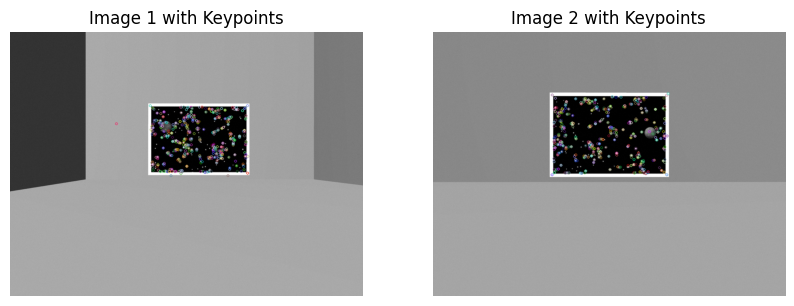

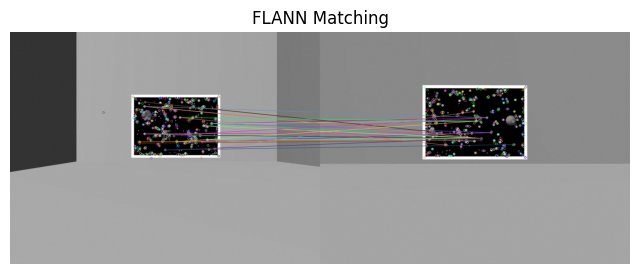

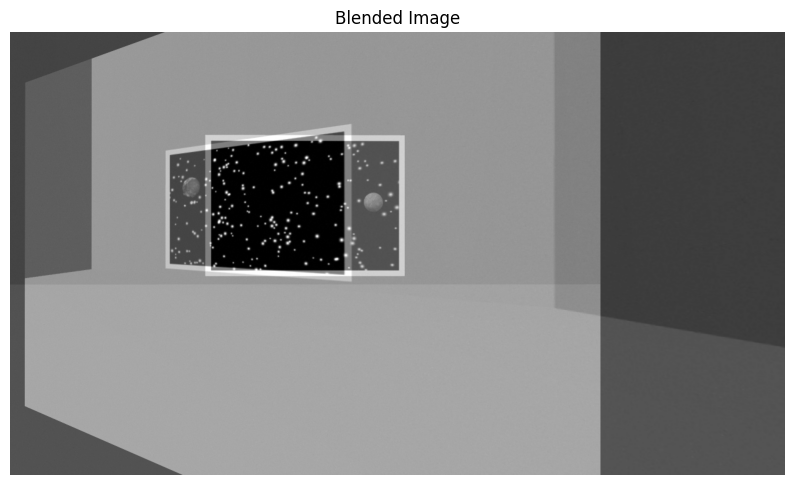

In [17]:
# Read the images
image1 = cv2.imread('/content/frame0000.jpg')
image2 = cv2.imread('/content/frame0001.jpg')

# Convert images to grayscale
gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Initialize SIFT feature detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors for both images
keypoints1, descriptors1 = sift.detectAndCompute(gray_image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray_image2, None)

# # Draw keypoints on the images
image1_keypoints = cv2.drawKeypoints(gray_image1, keypoints1, None)
image2_keypoints = cv2.drawKeypoints(gray_image2, keypoints2, None)

# Display the images with keypoints using Matplotlib
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image1_keypoints, cv2.COLOR_BGR2RGB))
plt.title('Image 1 with Keypoints')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image2_keypoints, cv2.COLOR_BGR2RGB))
plt.title('Image 2 with Keypoints')
plt.axis('off')

# Initialize FLANN matcher
index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Match the descriptors using FLANN matching
matches_flann = flann.match(descriptors1, descriptors2)
matches_flann = sorted(matches_flann, key=lambda x: x.distance)
# Draw the top N matches using FLANN
num_matches = 50
image_matches_flann = cv2.drawMatches(gray_image1, keypoints1, gray_image2, keypoints2, matches_flann[:num_matches], None)

# Display the images with matches using FLANN
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(image_matches_flann, cv2.COLOR_BGR2RGB))
plt.title('FLANN Matching')
plt.axis('off')
plt.show()

# Extract matched keypoints
tp = np.float32([keypoints2[m.trainIdx].pt for m in matches_flann]).reshape(-1, 1, 2)
qp = np.float32([keypoints1[m.queryIdx].pt for m in matches_flann]).reshape(-1, 1, 2)

# Estimate homography matrix using RANSAC
homography, _ = cv2.findHomography(qp, tp, cv2.RANSAC, 5.0)

# Warp the first image using the homography
result = cv2.warpPerspective(gray_image1, homography, (gray_image2.shape[1] + 300, gray_image2.shape[0]))

# Blend the warped image with the second image using alpha blending
alpha = 0.5  # blending factor
padded_left_img = cv2.copyMakeBorder(gray_image2, 0, 0, 0, result.shape[1] - gray_image2.shape[1], cv2.BORDER_CONSTANT)
blended_image = cv2.addWeighted(padded_left_img, alpha, result, 1 - alpha, 0)

# Display the blended image using Matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
plt.title('Blended Image')
plt.axis('off')
plt.show()

# Using ABJastroalign

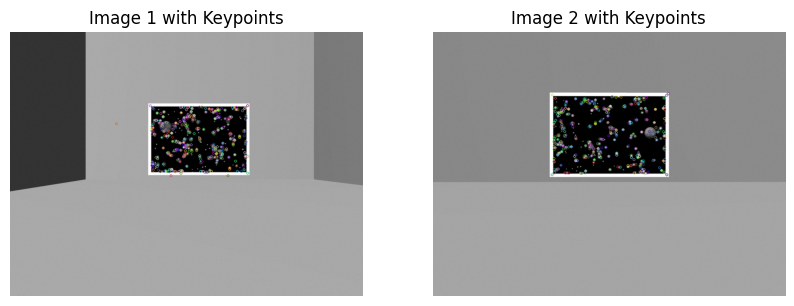

filtered
[[471.6572876  302.67095947]
 [472.34503174 315.44854736]
 [474.16027832 292.9057312 ]
 [476.94638062 309.53738403]
 [480.06134033 307.24102783]
 [482.72872925 309.62554932]
 [484.29782104 276.10040283]
 [484.43057251 271.76144409]
 [489.70025635 293.07217407]
 [493.32958984 292.30331421]
 [540.29205322 381.39419556]
 [542.64233398 342.84042358]
 [548.81195068 345.13348389]
 [548.91455078 309.88183594]
 [551.83630371 317.95599365]
 [552.1932373  322.14544678]
 [552.63378906 310.27832031]
 [552.63793945 325.84008789]
 [553.48950195 275.0447998 ]
 [554.80310059 313.35354614]
 [555.48858643 316.75769043]
 [555.72558594 322.13497925]
 [556.42468262 342.59844971]
 [558.78308105 317.25558472]
 [560.16381836 338.34912109]
 [561.42108154 357.3656311 ]
 [562.97259521 351.04434204]
 [563.21539307 325.63311768]
 [568.39349365 234.69241333]
 [571.4788208  325.29354858]
 [573.15313721 332.80264282]
 [573.48187256 329.94052124]
 [573.73388672 341.11236572]
 [574.31787109 314.65304565]
 [575

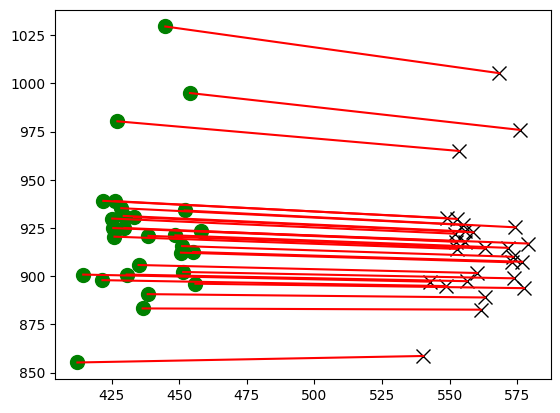

Transform <SimilarityTransform(matrix=
    [[ 1.18700483e+00, -3.73548696e-04, -2.29654375e+02],
     [ 3.73548696e-04,  1.18700483e+00, -6.75604835e+01],
     [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])>
Translation  [-229.65437466  -67.56048346]
scale  1.187004892754126
rotation angle  0.00031469853650545007


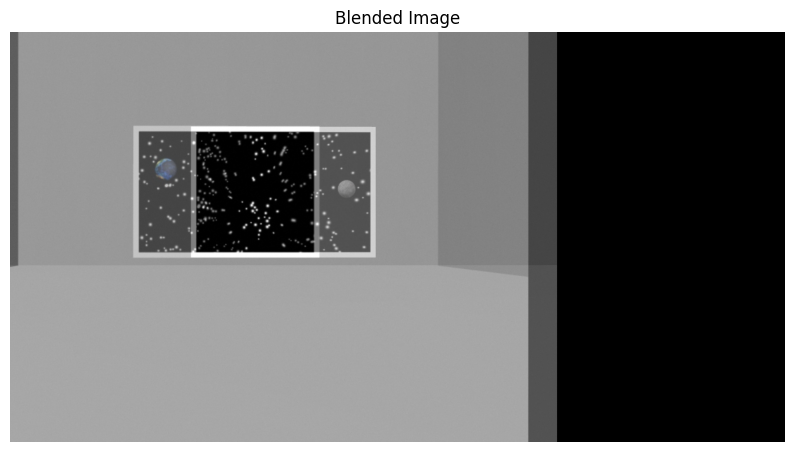

Source Keypoints:
(703, 2)
Target Keypoints:
(654, 2)


In [24]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import astroalign as aa
from skimage.measure import ransac
from skimage.transform import AffineTransform

# Read the images
right_img = cv2.imread('/content/frame0000.jpg')
left_img = cv2.imread('/content/frame0001.jpg')


# Convert images to grayscale
gray_right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)
gray_left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)

# Initialize SIFT
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors for both images
r_keypoints, r_descriptors = sift.detectAndCompute(gray_right_img, None)
l_keypoints, l_descriptors = sift.detectAndCompute(gray_left_img, None)

# # Draw keypoints on the images
image1_keypoints = cv2.drawKeypoints(gray_right_img, r_keypoints, None)
image2_keypoints = cv2.drawKeypoints(gray_left_img, l_keypoints, None)

# Display the images with keypoints using Matplotlib
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image1_keypoints, cv2.COLOR_BGR2RGB))
plt.title('Image 1 with Keypoints')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image2_keypoints, cv2.COLOR_BGR2RGB))
plt.title('Image 2 with Keypoints')
plt.axis('off')

plt.show()


# Convert keypoints to numpy arrays
source = np.array([[p.pt[0], p.pt[1]] for p in r_keypoints], dtype=np.float64).reshape(-1, 2)
target = np.array([[p.pt[0], p.pt[1]] for p in l_keypoints], dtype=np.float64).reshape(-1, 2)

# Create a FLANN matcher
index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Match descriptors using FLANN
matches = flann.knnMatch(r_descriptors, l_descriptors, k=2)

# Filter matches using ratio test
good_matches = []
for m, n in matches:  # Iterate over three nearest neighbors
    if m.distance < 0.7 * n.distance:  # Use ratio test
        good_matches.append(m)

# Extract matched keypoints
matched_r_keypoints = [r_keypoints[m.queryIdx].pt for m in good_matches]
matched_l_keypoints = [l_keypoints[m.trainIdx].pt for m in good_matches]

# Convert matched keypoints to homogeneous coordinates
matched_r_keypoints_homogeneous = np.hstack((matched_r_keypoints, np.ones((len(matched_r_keypoints), 1))))
matched_l_keypoints_homogeneous = np.hstack((matched_l_keypoints, np.ones((len(matched_l_keypoints), 1))))

# Define RANSAC model (Affine transformation)
model, inliers = ransac((matched_r_keypoints_homogeneous, matched_l_keypoints_homogeneous),
                        AffineTransform, min_samples=3, residual_threshold=3, max_trials=10000)

# Extract inlier matched keypoints
inlier_matched_r_keypoints = np.array(matched_r_keypoints)[inliers]
inlier_matched_l_keypoints = np.array(matched_l_keypoints)[inliers]

# Convert inlier matched keypoints to NumPy arrays
r_keypoint_array_filtered = np.array(inlier_matched_r_keypoints)
l_keypoint_array_filtered = np.array(inlier_matched_l_keypoints)
print('filtered')
r_keypoint_array_filtered = np.unique(r_keypoint_array_filtered, axis=0)
l_keypoint_array_filtered = np.unique(l_keypoint_array_filtered, axis=0)
print(r_keypoint_array_filtered)
print(l_keypoint_array_filtered)

# Check if any keypoints were filtered out
if len(r_keypoint_array_filtered) == 0 or len(l_keypoint_array_filtered) == 0:
    print("Warning: No valid keypoints found. Ensure the images have enough features.")
else:
    # Find the transformation matrix using astroalign.find_transform
    try:
        transf, (src_pts, dst_pts) = aa.find_transform(r_keypoint_array_filtered, l_keypoint_array_filtered)
        print("Transformation matrix found successfully.")

        # If you want to display the points and the matches found
        plt.plot(src_pts[:, 0], 1240 - src_pts[:, 1], "xk", markersize=10)
        plt.plot(dst_pts[:, 0], 1240 - dst_pts[:, 1], "og", markersize=10)


        # Display correspondences
        for i in range(len(src_pts)):
            plt.plot([src_pts[i, 0], dst_pts[i, 0]],
                            [1240-src_pts[i, 1], 1240-dst_pts[i, 1]], "-r")

        plt.show()


        # To diplay the matrix you can use
        print("Transform",transf)


        # and for its components

        print("Translation ",transf.translation)
        print("scale ",transf.scale)
        print("rotation angle ", transf.rotation)


        # Convert transform to form OpenCV can use
        homography = np.matrix(transf, np.float32)


        # Apply transform to right image
        result = cv2.warpPerspective(right_img, homography, (left_img.shape[1]+400, left_img.shape[0]),flags=cv2.INTER_LINEAR)

        # Blending the warped image with the second image using alpha blending
        padded_left_img = cv2.copyMakeBorder(left_img, 0, 0, 0, result.shape[1] - left_img.shape[1],cv2.BORDER_CONSTANT )
        alpha = 0.5  # blending factor
        blended_image = cv2.addWeighted(padded_left_img, alpha, result, 1 - alpha, 0)

        # Display the blended image
        # Convert BGR image to RGB (OpenCV reads images in BGR format)
        blended_image_rgb = cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB)

        # Display the blended image using matplotlib
        plt.figure(figsize=(10, 8))  # Adjust figure size if needed
        plt.imshow(blended_image_rgb)
        plt.title('Blended Image')
        plt.axis('off')  # Hide axis
        plt.show()

    except ValueError as e:
        print(f"Failed to find transformation matrix: {e}")

# Print source and target arrays
print("Source Keypoints:")
print(source.shape)
print("Target Keypoints:")
print(target.shape)
source = np.array(source)



